1. Напишите функцию, которая подбирает оптимальные параметры для double_ema и ряда Monthly Boston armed robberies

2. Взять с прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

In [12]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [3]:
sales_of_company_x = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

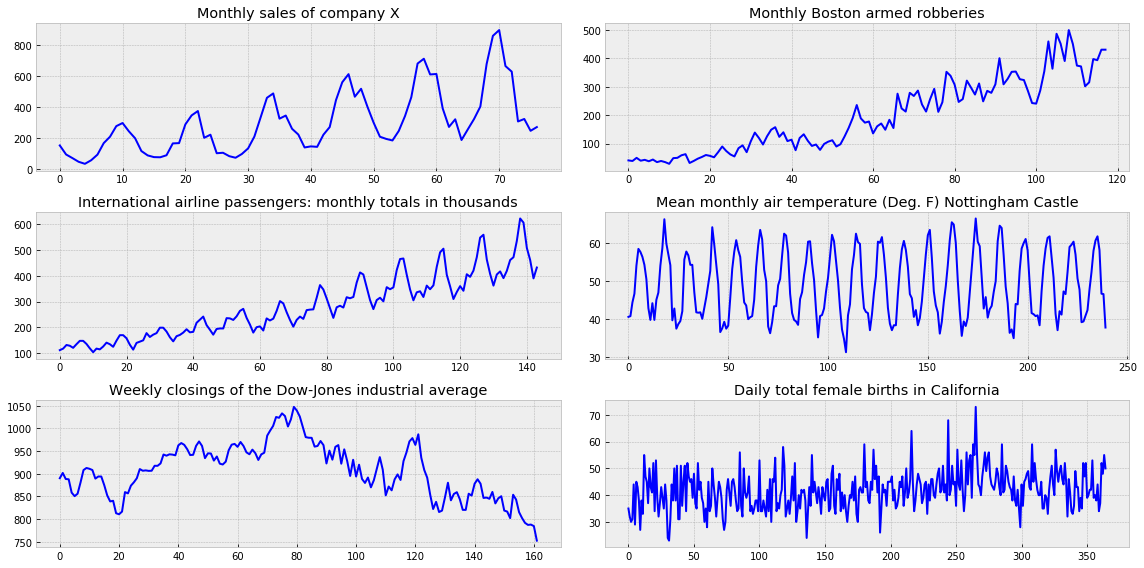

In [6]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

Задание 1.

In [7]:
# напишем функцию, которая умеет строить модель двойного экспоненциального сглаживания и делать предсказания
def double_ema_pred(series, alpha, beta, n_pred = None):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    if not n_pred:
        return pd.Series(result)
    
    if n_pred:
        predictions = []
    
    
    
    for i in range(n_pred):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        predictions.append(level+trend)
        
    series_with_preds = series.append(pd.Series(predictions), ignore_index=True)
    
    return series_with_preds

In [8]:
# определяем серию, с которой будем работать
series = robberies_in_boston["Count"]

In [9]:
# разбиваем на трейн и тест
train, test = series[:70], series[70:]

In [65]:
# функция для определения RMSE
def mse(X):
    alpha, beta = X
    result = double_ema_pred(train, alpha, beta, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [13]:
# определяем лучшие параметры
opt = minimize(mse, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

In [14]:
alpha_opt, beta_opt = opt.x

In [15]:
print(opt)

      fun: 5416.669445064098
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-35.57688615,   0.        ])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 45
      nit: 13
   status: 0
  success: True
        x: array([1.        , 0.76353559])


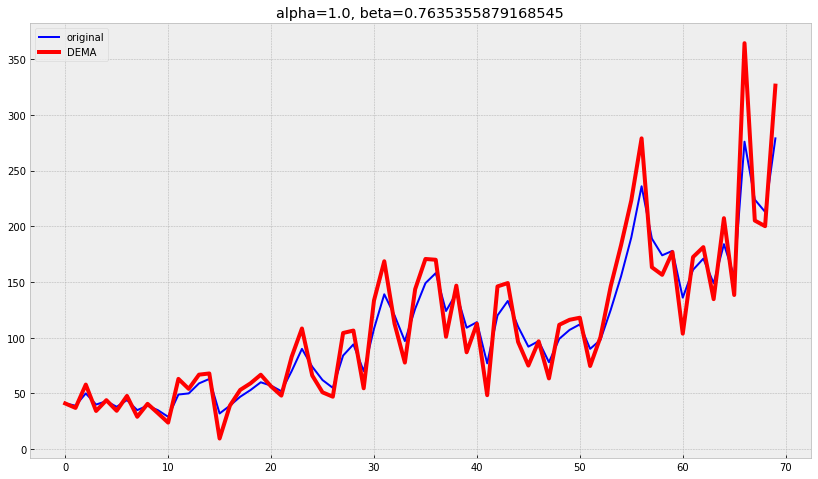

In [16]:
# визуализируем получившийся ряд с подобранными параметрами и оригинальный
dema = double_ema_pred(train, alpha_opt, beta_opt)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(train, color='blue',label='original')
    plt.plot(dema, color='red', linewidth='4', label='DEMA')
    plt.title("alpha={}, beta={}".format(alpha_opt, beta_opt))
    plt.legend()

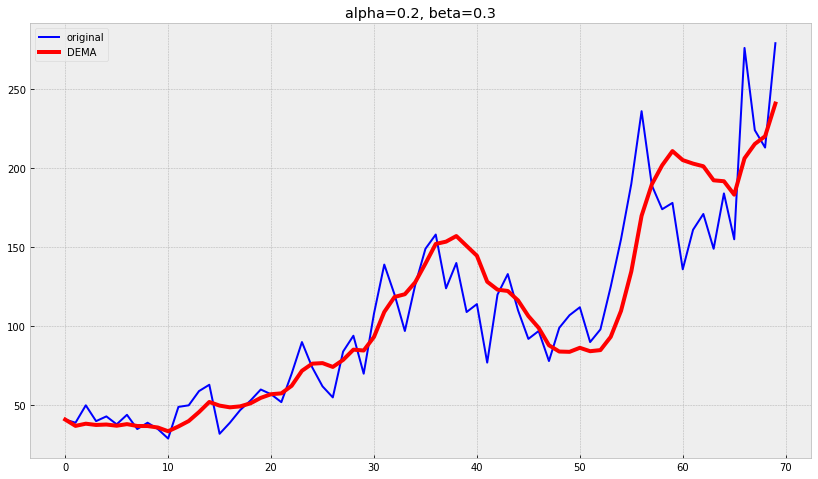

In [17]:
# для сравнения какие-то другие значения alpha betta
dema_random = double_ema_pred(train, 0.2, 0.3)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(train, color='blue',label='original')
    plt.plot(dema_random, color='red', linewidth='4', label='DEMA')
    plt.title("alpha={}, beta={}".format(0.2, 0.3))
    plt.legend()

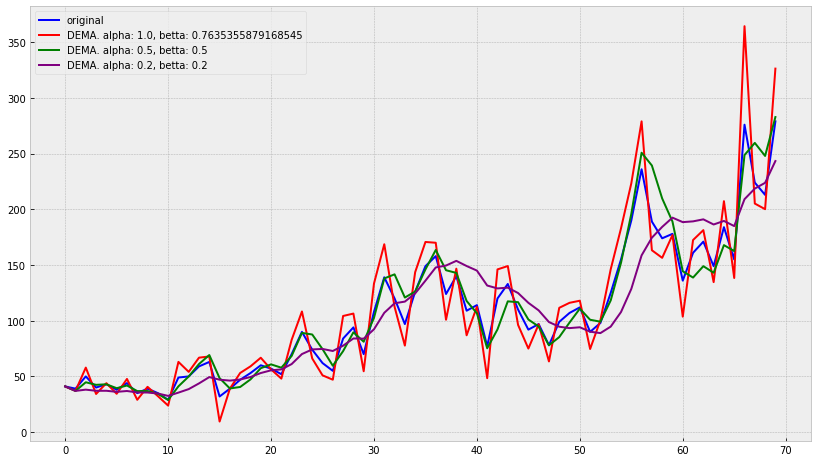

In [20]:
# визуализируем для разных параметров
alphas = [alpha_opt, 0.5,0.2]
bettas = [beta_opt, 0.5,0.2]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(train, color='blue',label='original')
    for i in range(len(alphas)):
        
        ser = double_ema_pred(train, alphas[i], bettas[i], n_pred = None)
        plt.plot(ser, color=colors[i], linewidth='2', label='DEMA. alpha: {0}, betta: {1}'.format(alphas[i], bettas[i]))
    plt.legend()

Задание 2

Взять с прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

In [25]:
# возьмем sales_of_company_x (не стационарный) и female_births (условно стационарный)


2.1 Скользящее среднее

2.1.1. Скользящее среднее для sales_of_company_x

In [35]:
series = sales_of_company_x["Count"]

In [36]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [37]:
ser = moving_average(series, 7) # произвольный размер окна

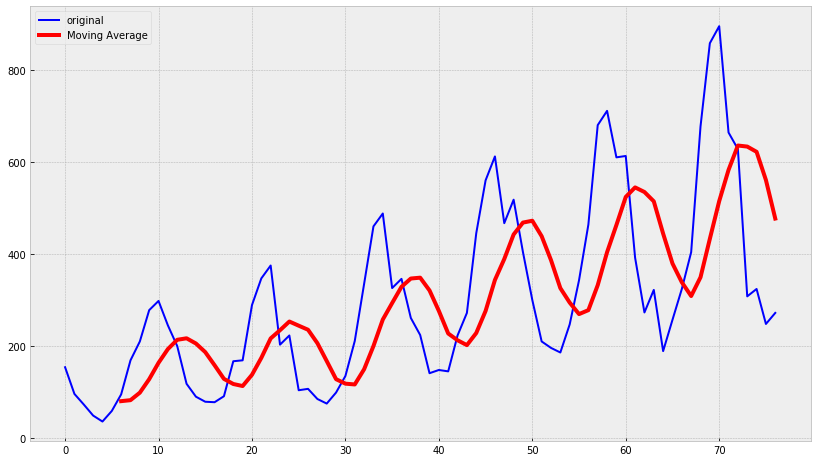

In [38]:
ser = moving_average(series, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(sales_of_company_x["Count"], color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

In [41]:
# определим границу, до которой будет трейн, после которой тест
board = round(series.shape[0] * 0.7)
board

54

In [42]:
train = series[:board]
test = series[board:]

In [43]:
# Предсказываем значения на основнии train
def predict_ser(series, n_pred, window):
    new_ser = series.copy()
    for i in range(n_pred):
        new_ser = new_ser.append(pd.Series([new_ser[-window:].mean()]), ignore_index=True)
    return new_ser

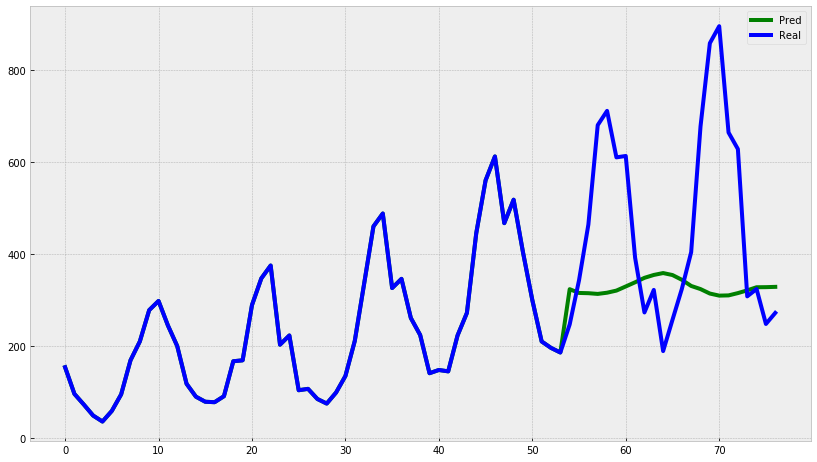

In [58]:
series_pred = predict_ser(train, len(test), 20)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_pred, color='green', linewidth = '4', label = 'Pred')
    plt.plot(series, color='blue', linewidth = '4', label = 'Real')
    plt.legend()

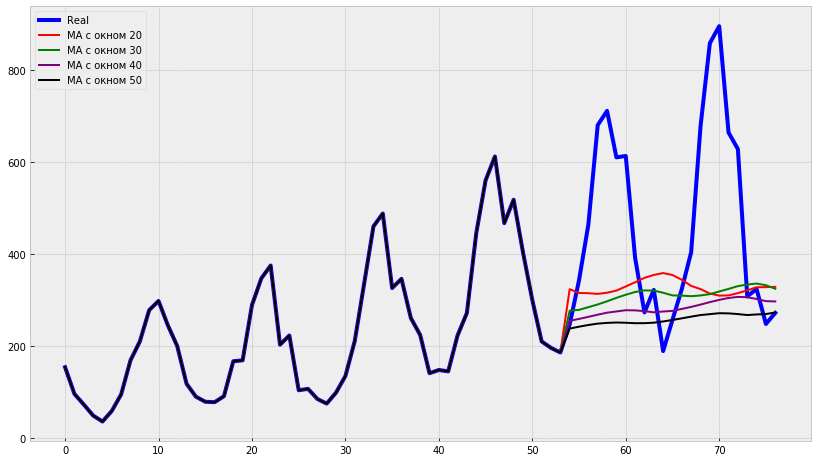

In [60]:
windows = [20,30,40,50]
colors = ['red', 'green', 'purple', 'black']
    
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue', linewidth = '4', label = 'Real')
    for i in range(len(windows)):
        series_pred = predict_ser(train, len(test), windows[i])
        plt.plot(series_pred, color=colors[i], linewidth = '2', label = 'MA с окном {}'.format(windows[i]))
    plt.legend()

In [67]:
# функция для определения RMSE
def mse_2(X):
    window = X
    result = predict_ser(train, len(test), window)
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [95]:
y = [mse_2(x) for x in range(1,101)]
x = list(range(1,101))

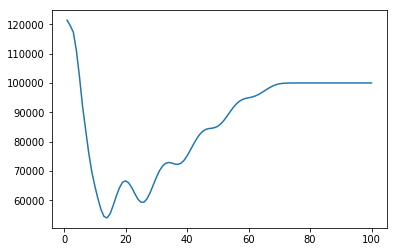

In [97]:
# посмотрим, при каком значении ошибка минимальна
plt.plot(x, y)

In [101]:
# минимальное (лучшее) значение ошибки
np.min(y)

54037.938988138696

In [118]:
# найдем икс, кторому соответствует это значение 
for i, j in zip(x,y):
    if j <= np.min(y):
        print (i)

14


In [119]:
mse_2(14)

54037.938988138696

2.1.2. Скользящее среднее для female_births

In [120]:
series = female_births["Count"]

In [121]:
# определим границу, до которой будет трейн, после которой тест
board = round(series.shape[0] * 0.7)
board


255

In [122]:

train = series[:board]
test = series[board:]

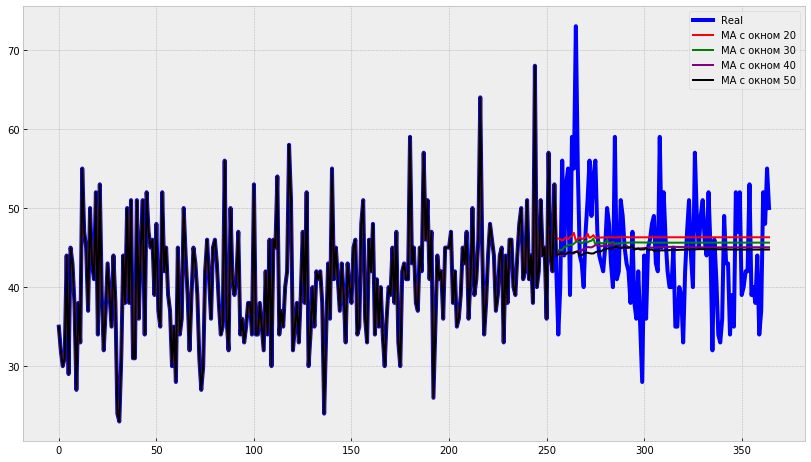

In [123]:
windows = [20,30,40,50]
colors = ['red', 'green', 'purple', 'black']
    
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue', linewidth = '4', label = 'Real')
    for i in range(len(windows)):
        series_pred = predict_ser(train, len(test), windows[i])
        plt.plot(series_pred, color=colors[i], linewidth = '2', label = 'MA с окном {}'.format(windows[i]))
    plt.legend()

In [124]:
y = [mse_2(x) for x in range(1,101)]
x = list(range(1,101))

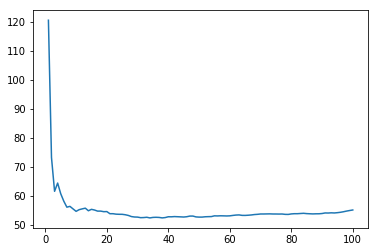

In [125]:
# посмотрим, при каком значении ошибка минимальна
plt.plot(x, y)


In [126]:
# минимальное (лучшее) значение ошибки
np.min(y)

52.37820302636188

In [127]:
# найдем икс, кторому соответствует это значение 
for i, j in zip(x,y):
    if j <= np.min(y):
        print (i)

34


In [129]:
mse_2(34)

52.37820302636188

2.1.3. Вывод

Прогноз на основе moving average получается ужасным

## 2.2 Взвешенное скользящее среднее

2.2.1. Взвешенное скользящее среднее для sales_of_company_x

In [301]:
series = sales_of_company_x["Count"]

In [133]:
# определим границу, до которой будет трейн, после которой тест
board = round(series.shape[0] * 0.7)
board


54

In [302]:
train = series[:board]
test = series[board:]

In [186]:
# функция, приближающая ряд
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return pd.Series([np.NaN]).append(wma, ignore_index=True)

In [216]:
def weighted_moving_average_pred(series, n, weights, n_pred):
    """series - временной ряд, n - на сколько значений смотрим назад (окно),
    weights - веса (должно быть столько, сколько n), n_pred - кол-во предсказаний"""
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, np.ndarray):
        series = np.array(series)
    new_ser = series.copy()
    wma = pd.Series(new_ser).rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)

    for i in range(n_pred):
        pred = (wma[-n:] * weights[::-1]).sum() / weights.sum()
        wma = np.append(wma, pred)
    
    return pd.Series(wma)

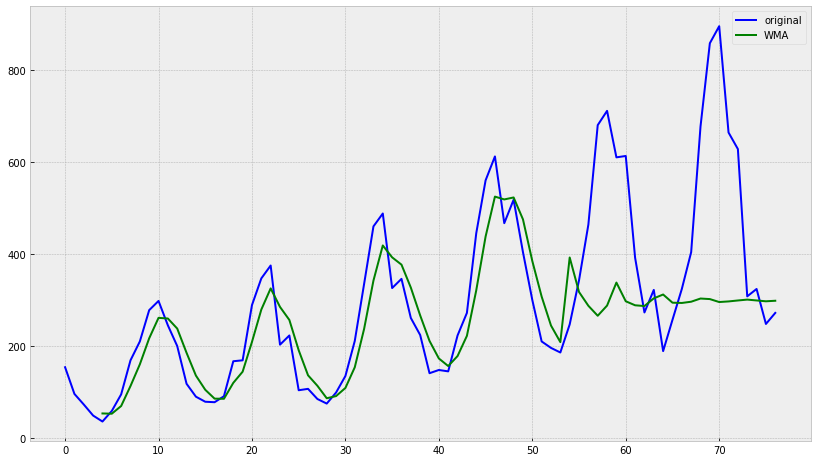

In [221]:
wma = weighted_moving_average_pred(train, 5, [0,1,1,2,3], len(test))
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

In [225]:
windows = [5,10,20,40]
colors = ['red', 'green', 'purple', 'black']    


In [226]:
def fibonacci(n):
    fib1, fib2 = 0, 1
    for i in range(n):
        fib1, fib2 = fib2, fib1 + fib2
        yield fib1

In [229]:
weights_fib = [list(fibonacci(x)) for x in windows]

In [230]:
windows = [5,10,20,40]
colors = ['red', 'green', 'purple', 'black']
weights  = weights_fib

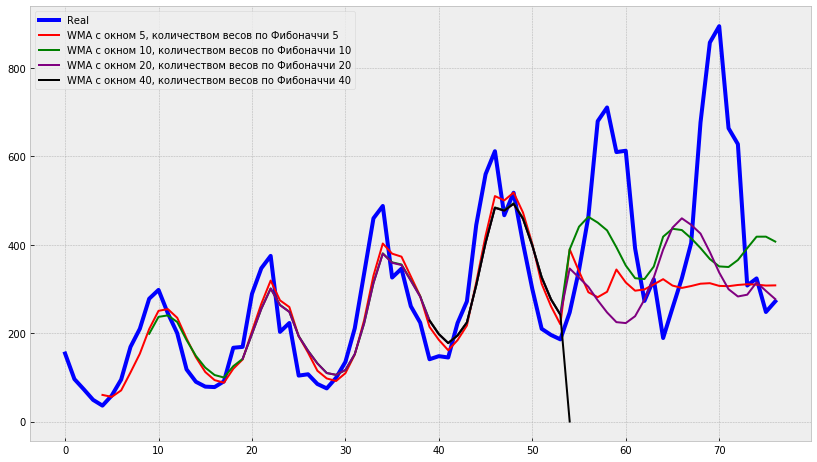

In [234]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue', linewidth = '4', label = 'Real')
    for i in range(len(windows)):
        series_pred = weighted_moving_average_pred(train, len(weights[i]), weights[i], len(test))
        plt.plot(series_pred, color=colors[i], linewidth = '2', 
                 label = 'WMA с окном {}, количеством весов по Фибоначчи {}'.format(windows[i], len(weights[i])))
    plt.legend()

In [255]:
# интересно посмотреть результаты для весов не Фибоначчи, а степеней двойки
weights_powers_of_two = []
for i in windows:
    weights_powers_of_two.append([2**x for x in range(i)])

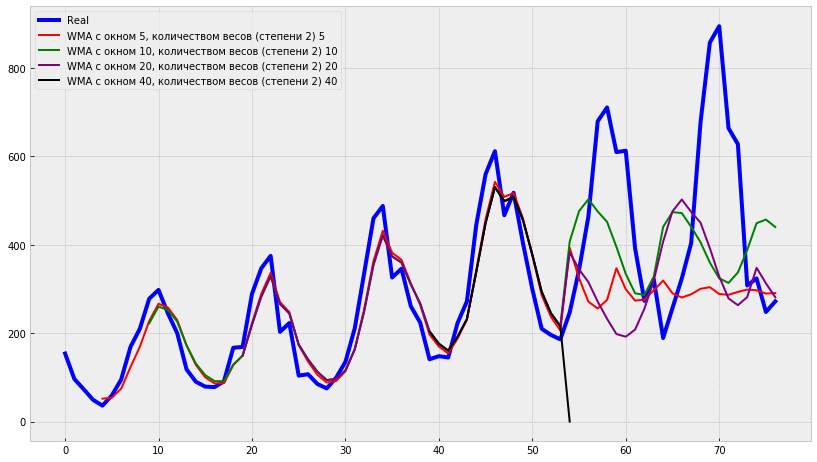

In [257]:
windows = [5,10,20,40]
colors = ['red', 'green', 'purple', 'black']  
weights = weights_powers_of_two

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue', linewidth = '4', label = 'Real')
    for i in range(len(windows)):
        series_pred = weighted_moving_average_pred(train, len(weights[i]), weights[i], len(test))
        plt.plot(series_pred, color=colors[i], linewidth = '2', 
                 label = 'WMA с окном {}, количеством весов (степени 2) {}'.format(windows[i], len(weights[i])))
    plt.legend()

In [258]:
# разницы особой не видно

In [308]:
# функция для определения RMSE
def mse_3(X):
    window = X
    result = weighted_moving_average_pred(train, window, list(fibonacci(window)), len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error


In [315]:
# функция выдает ошибку при 0 и X выше 28
error_dict = {}
for i in range(len(train)):
    try:
        print(mse_3(i))
        error_dict[i] = mse_3(i)
    except:
        print('error')

error
121387.0
116438.41575051735
101515.80177760565
82905.05584087544
69251.5555777372
61454.20780063089
57851.427770909795
53855.11548970758
54769.11699064394
53336.005372053085
42836.56259796391
35435.12801828996
41810.81284430128
59453.30660078897
77507.74282500045
87723.0473181107
90379.96644997406
88112.80710338602
82432.25390707438
73325.86181080333
62942.07794599577
52820.37085053002
46242.874147051174
45832.19370638137
52939.8682061382
65826.2012864404
81979.64931483373
98032.6341635127
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error


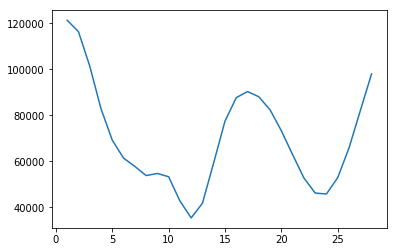

In [318]:
plt.plot(pd.Series(error_dict))

In [328]:
# найдем икс, которому соответствует это значение 
for key, value in error_dict.items():
    if value <= np.min(list(error_dict.values())):
        print (key)

12


In [329]:
# минимальная ошибка при окне, равном 12 значений
error_dict[12]

35435.12801828996

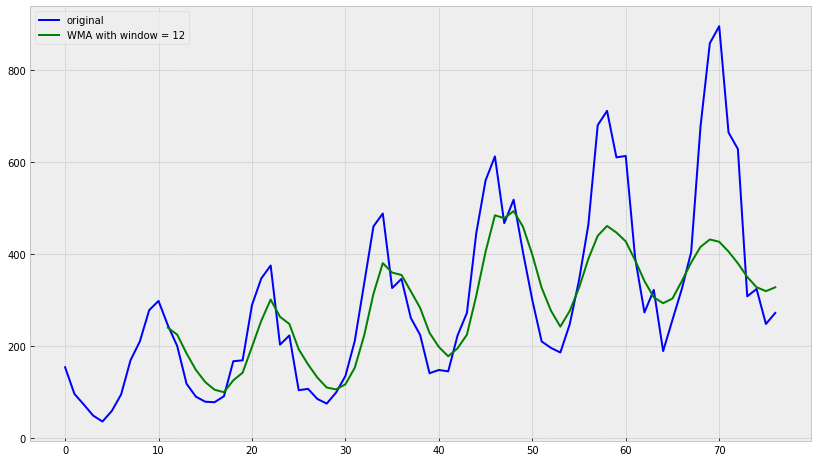

In [339]:
wma = weighted_moving_average_pred(train, 12, list(fibonacci(12)), len(test))
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(wma, color='green', linewidth='2', label='WMA with window = 12')
    plt.legend()

In [362]:
# полученное значение ошибки 35435.12801828996 лучше, чем 54037.938988138696 при MA

2.2.2. Взвешенное скользящее среднее для female_births

In [340]:
series =female_births["Count"]


In [341]:
# определим границу, до которой будет трейн, после которой тест
board = round(series.shape[0] * 0.7)
board

255

In [342]:
train = series[:board]
test = series[board:]

In [343]:
weights_fib = [list(fibonacci(x)) for x in windows]

windows = [5,10,20,40]
colors = ['red', 'green', 'purple', 'black']
weights  = weights_fib

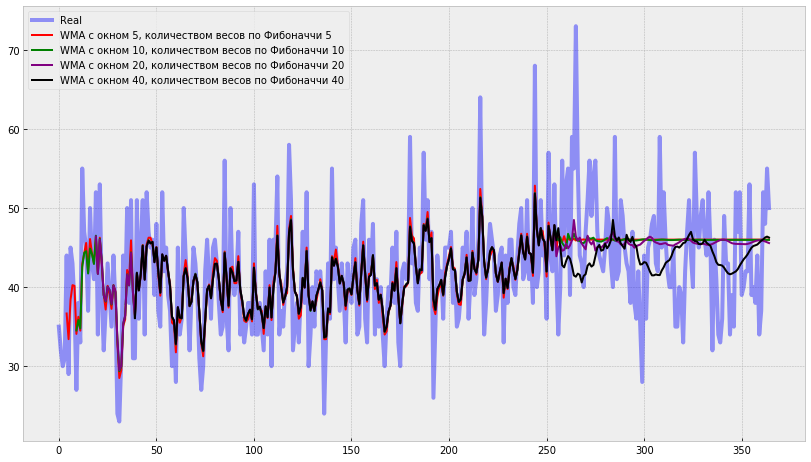

In [346]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue', linewidth = '4', label = 'Real', alpha=0.4)
    for i in range(len(windows)):
        series_pred = weighted_moving_average_pred(train, len(weights[i]), weights[i], len(test))
        plt.plot(series_pred, color=colors[i], linewidth = '2', 
                 label = 'WMA с окном {}, количеством весов по Фибоначчи {}'.format(windows[i], len(weights[i])))
    plt.legend()

In [359]:
# функция выдает ошибку при 0 и X выше 28
error_dict = {}
for i in range(len(train)):
    try:
        #print(mse_3(i))
        error_dict[i] = mse_3(i)
    except:
        pass
        #print('error')

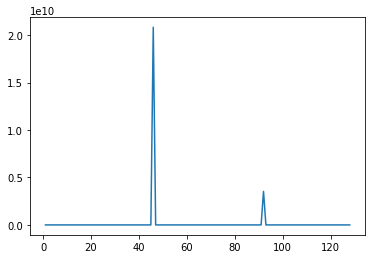

In [360]:
# какие-то аномальные всплески ошибок
plt.plot(pd.Series(error_dict))

In [354]:
# найдем икс, кторому соответствует это значение 
for key, value in error_dict.items():
    if value <= np.min(list(error_dict.values())):
        print (key)


21


In [355]:

# минимальная ошибка при окне, равном 12 значений
error_dict[21]

49.38035034682809

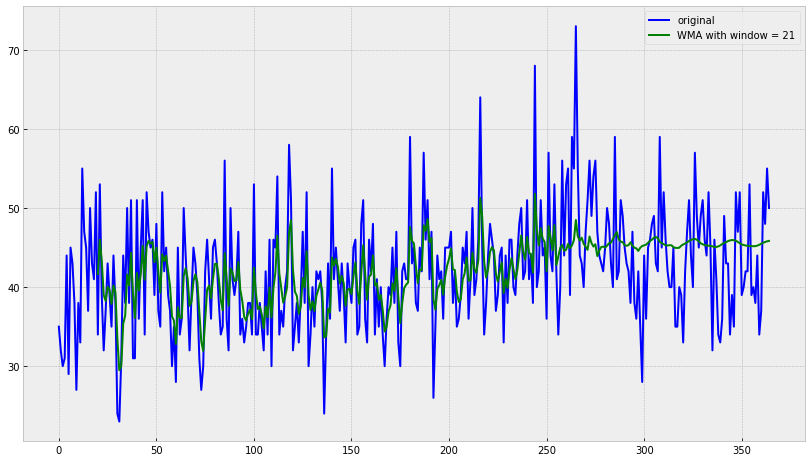

In [356]:
wma = weighted_moving_average_pred(train, 21, list(fibonacci(21)), len(test))
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(wma, color='green', linewidth='2', label='WMA with window = 21')
    plt.legend()


In [361]:
# уже лучше. Полученное значение 49.38035034682809 лучше, чем при MA (52.37820302636188)

## 2.3 Экспоненциальное сглаживание

Мы хотим учитывать на самом деле учитывать не какой-то фиксированный набор измерений. В идеале - мы хотим учитывать всю историю измерений, накопившуюся к текущему моменту. Просто, как и в случае WMA, чем дальше измерение - тем меньше вклад. Для этого используется экспоненциальное скользящее среднее:

$$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $$

В нем предсказанное значение - это взвешеное срденее между последним наблюдением и предыдущей историей. Легко заметить, что формула рекурсивна. Параметр $\alpha$ называется сглаживающим фактором. Он определяет, как сильно мы будем опираться на историю (чем меньше - тем больше). Чем меньше $\alpha$, тем больше влияния оказывают предыдущие предсказанные значения, и тем сильнее сглаживается ряд. 

2.3.1. Экспоненциальное сглаживание для sales_of_company_x

In [363]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [364]:
ema = exponential_moving_average(sales_of_company_x["Count"], 0.2)

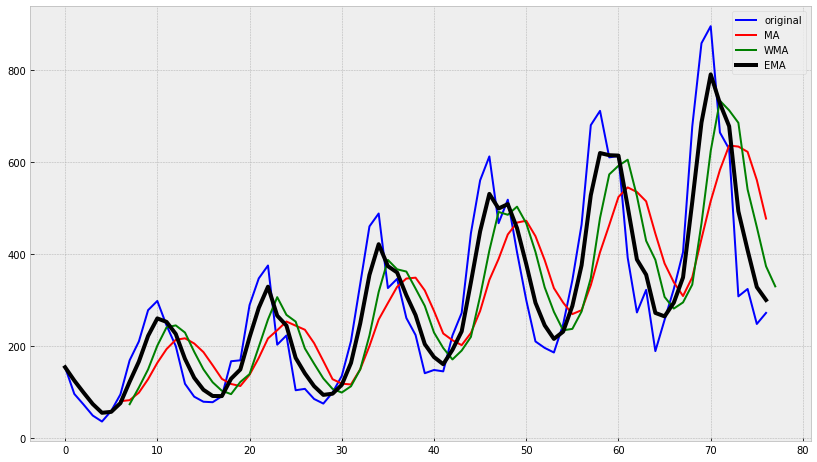

In [365]:
# сравним с предыдущим алгоритмами
ema = exponential_moving_average(sales_of_company_x["Count"], 0.5)
wma = weighted_moving_average(sales_of_company_x["Count"], 7, [1,1,2,3,5,8,13])
ma = moving_average(sales_of_company_x["Count"], 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(sales_of_company_x["Count"], color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

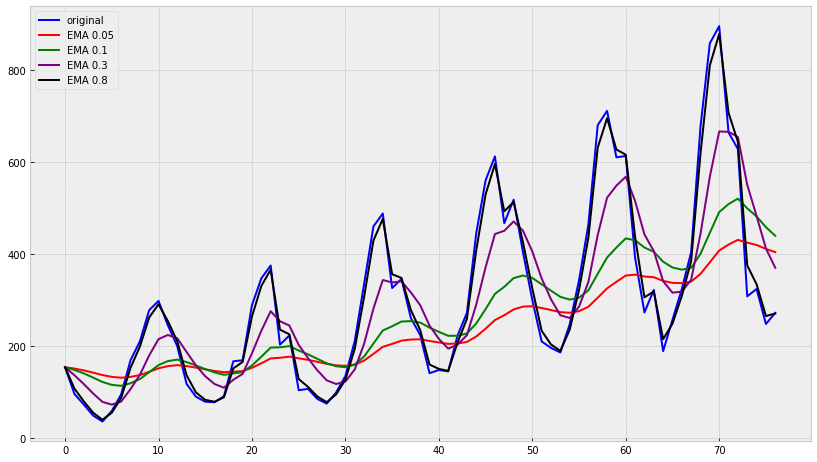

In [366]:
alphas = [0.05,0.1,0.3,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(sales_of_company_x["Count"], color='blue',label='original')
    for i in range(len(alphas)):
        ser = exponential_moving_average(sales_of_company_x["Count"], alphas[i])
        plt.plot(ser, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.legend()

In [369]:
series = sales_of_company_x["Count"]

# определим границу, до которой будет трейн, после которой тест
board = round(series.shape[0] * 0.7)
board


54

In [370]:
# разбиваем на трейн и тест
train, test = series[:board], series[board:]

In [372]:
# напишем функцию для предсказания
def exponential_moving_average(series, alpha, n_pred = None):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    if not n_pred:
        return pd.Series(result)
    
    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]
    
    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)
    
    return series.append(pd.Series(predictions), ignore_index = True), pd.Series(result)

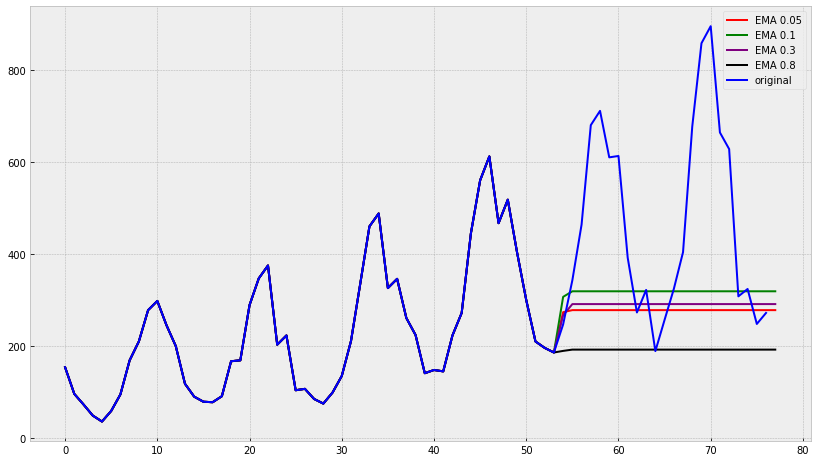

In [374]:
alphas = [0.05, 0.1, 0.3, 0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    for i in range (len(alphas)):
        pred, _ = exponential_moving_average(train, alphas[i], len(test))
        plt.plot(pred, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.plot(series, color='blue', label='original')
    plt.legend()

In [448]:
# предсказания так себе. Даже не стоит считать RMSE

2.3.2. Экспоненциальное сглаживание для female_births

In [377]:
series = female_births['Count']

In [378]:
# определим границу, до которой будет трейн, после которой тест
board = round(series.shape[0] * 0.7)
board

255

In [379]:
# разбиваем на трейн и тест
train, test = series[:board], series[board:]

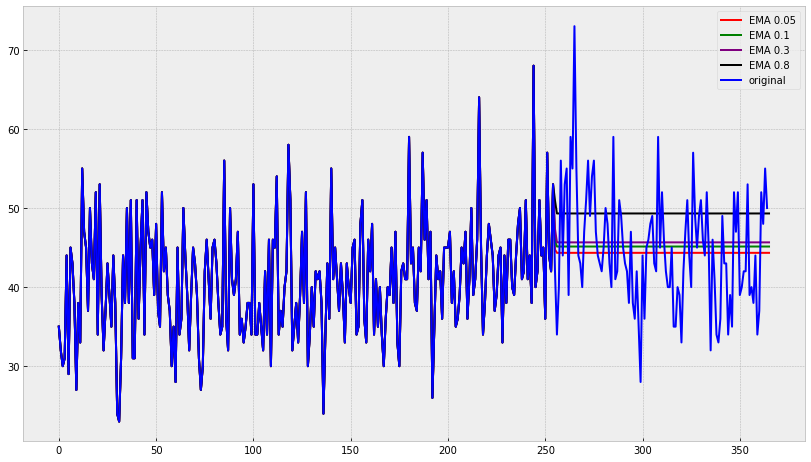

In [380]:
alphas = [0.05, 0.1, 0.3, 0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    for i in range (len(alphas)):
        pred, _ = exponential_moving_average(train, alphas[i], len(test))
        plt.plot(pred, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.plot(series, color='blue', label='original')
    plt.legend()

In [381]:
# предсказания так себе. В качестве определителя тренда тоже сомнительно. RMSE считать не будем

## 2.4 Двойное экспоненциальное сглаживание

2.4.1. Двойное экспоненциальное сглаживание для sales_of_company_x

In [382]:
series = sales_of_company_x["Count"]

In [383]:
# определим границу, до которой будет трейн, после которой тест
board = round(series.shape[0] * 0.7)
board


54

In [384]:
# разбиваем на трейн и тест
train, test = series[:board], series[board:]

In [385]:
def double_ema(series, alpha, beta):
    '''Функция для приближения'''
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [386]:
def plot_dema(alpha, beta):
    '''Функция для отрисовки'''
    dema = double_ema(series, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

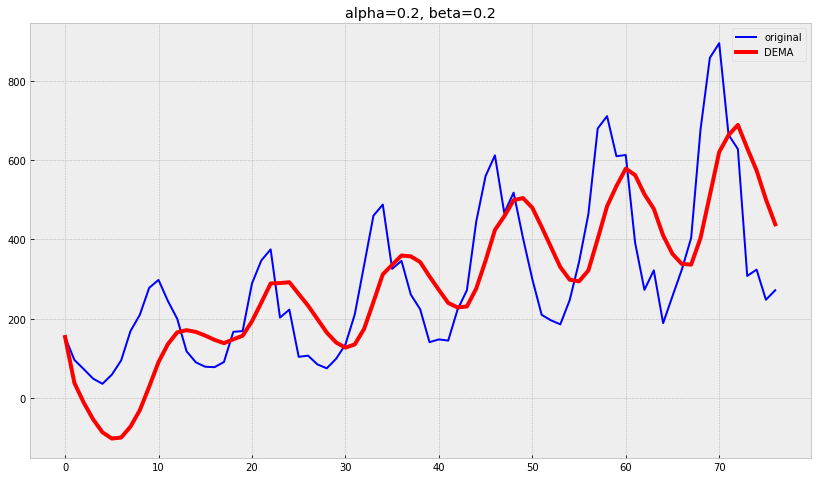

In [387]:
plot_dema(0.2, 0.2)

In [388]:
def double_ema_pred(series, alpha, beta, n_pred = None):
    """Функция для предсказания"""
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    if not n_pred:
        return pd.Series(result)
    
    if n_pred:
        predictions = []
    
    
    
    for i in range(n_pred):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        predictions.append(level+trend)
        
    series_with_preds = series.append(pd.Series(predictions), ignore_index=True)
    
    return series_with_preds

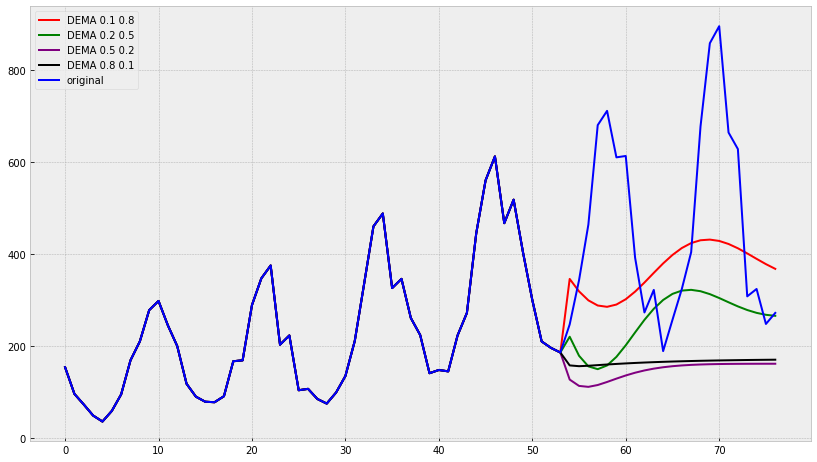

In [390]:
alphas = [0.1,0.2,0.5,0.8]
bettas = [0.8,0.5,0.2,0.1]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        ser = double_ema_pred(train, alphas[i], bettas[i], len(test))
        plt.plot(ser, color=colors[i], linewidth='2', label='DEMA {} {}'.format(alphas[i], bettas[i]))
    plt.plot(series, color='blue',label='original')
    plt.legend()

In [392]:
def mse(X):
    alpha, beta = X
    result = double_ema_pred(train, alpha, beta, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [393]:
opt = minimize(mse, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

In [394]:
alpha_opt, beta_opt = opt.x
print(opt)

      fun: 124293.08290019046
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([     0.        , -23787.20819252])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 39
      nit: 7
   status: 0
  success: True
        x: array([0.86967861, 1.        ])


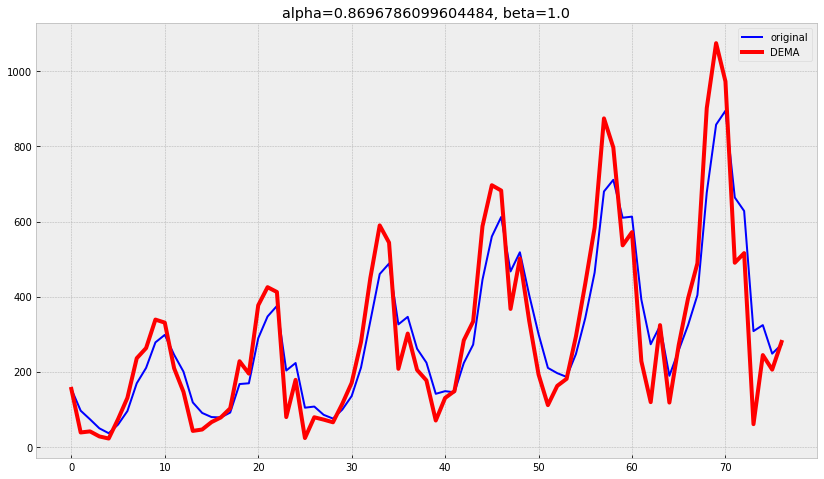

In [395]:
plot_dema(alpha_opt, beta_opt)

In [396]:
# посчитаем MSE
result = double_ema_pred(train, alpha_opt, beta_opt, len(test))
predictions = result[-len(test):]
error = mean_squared_error(predictions, test)
error

124293.08290019046

In [400]:
# значение MSE смущает, оно выше, чем у MA и WMA. Но судя по графику, модель DEMA намного лучше

2.4.2. Двойное экспоненциальное сглаживание для female_births

In [405]:
series = female_births["Count"]

In [406]:
# определим границу, до которой будет трейн, после которой тест
board = round(series.shape[0] * 0.7)
board

255

In [407]:
# разбиваем на трейн и тест
train, test = series[:board], series[board:]

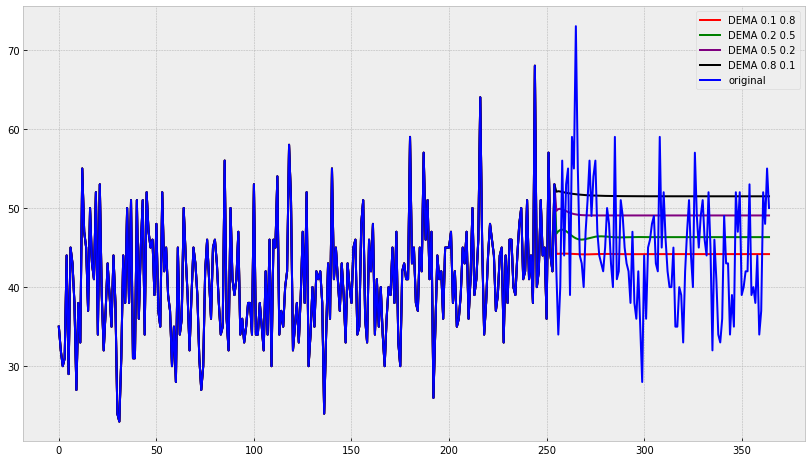

In [408]:
alphas = [0.1,0.2,0.5,0.8]
bettas = [0.8,0.5,0.2,0.1]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        ser = double_ema_pred(train, alphas[i], bettas[i], len(test))
        plt.plot(ser, color=colors[i], linewidth='2', label='DEMA {} {}'.format(alphas[i], bettas[i]))
    plt.plot(series, color='blue',label='original')
    plt.legend()

In [409]:
opt = minimize(mse, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

In [410]:
alpha_opt, beta_opt = opt.x
print(opt)

      fun: 48.096057911525506
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.06307843, 0.00427036])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 111
      nit: 16
   status: 0
  success: True
        x: array([0.02399378, 0.29192816])


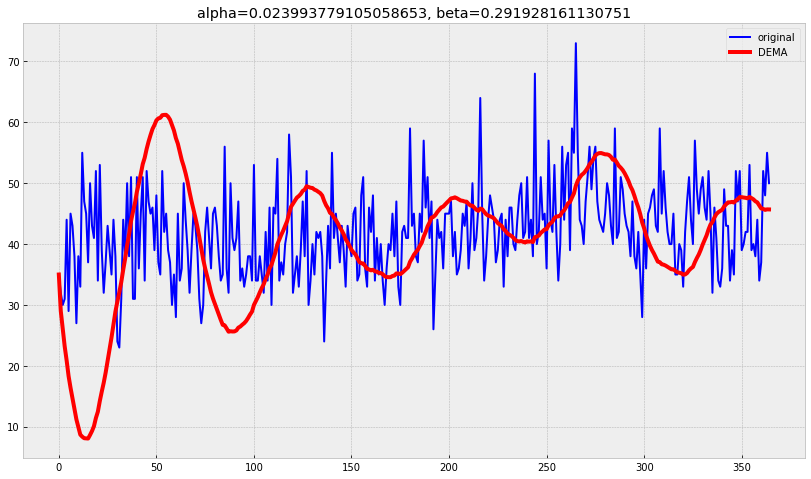

In [411]:
plot_dema(alpha_opt, beta_opt)

In [412]:
# для стационарной серии эта модель подходит плохо

In [413]:
# посчитаем MSE
result = double_ema_pred(train, alpha_opt, beta_opt, len(test))
predictions = result[-len(test):]
error = mean_squared_error(predictions, test)
error

48.096057911525506

In [414]:
# Хотя ошибка на тесте меньше, чем у MA и WMA. Может не так уж плохо подходит DEMA

## 2.5 Хольт-Винтерс (Тройное экспоненциальное сглаживание)

2.5.1. Тройное экспоненциальное сглаживание для sales_of_company_x

In [415]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [416]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [417]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [429]:
def plot_tema(alpha, beta, gamma, ser=sales_of_company_x["Count"], ser_to_plot=sales_of_company_x["Count"], n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

In [430]:
series = sales_of_company_x["Count"]

In [431]:
# определим границу, до которой будет трейн, после которой тест
board = round(series.shape[0] * 0.7)
board

54

In [432]:
# разбиваем на трейн и тест
train, test = series[:board], series[board:]

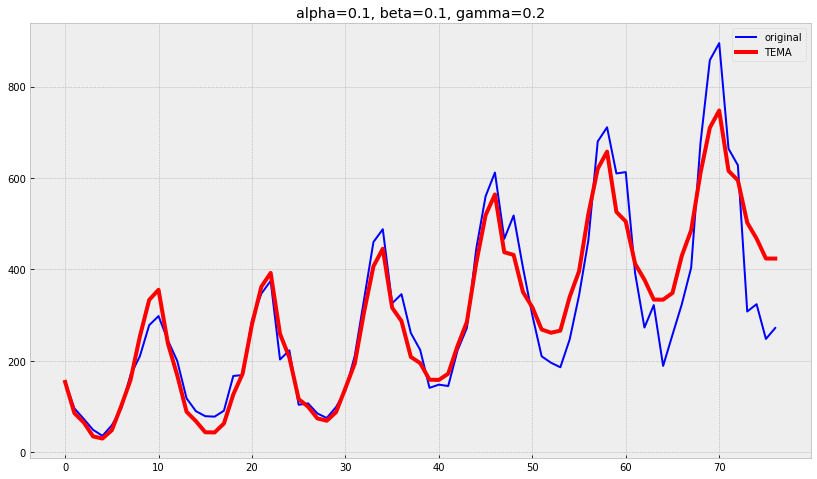

In [434]:
plot_tema(0.1, 0.1, 0.2, train, series, len(test))

In [435]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [436]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [437]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 5863.200338538195
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.59205990e-02, -4.77484718e-02, -3.45990766e+03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 140
      nit: 21
   status: 0
  success: True
        x: array([0.21471958, 0.04779291, 1.        ])


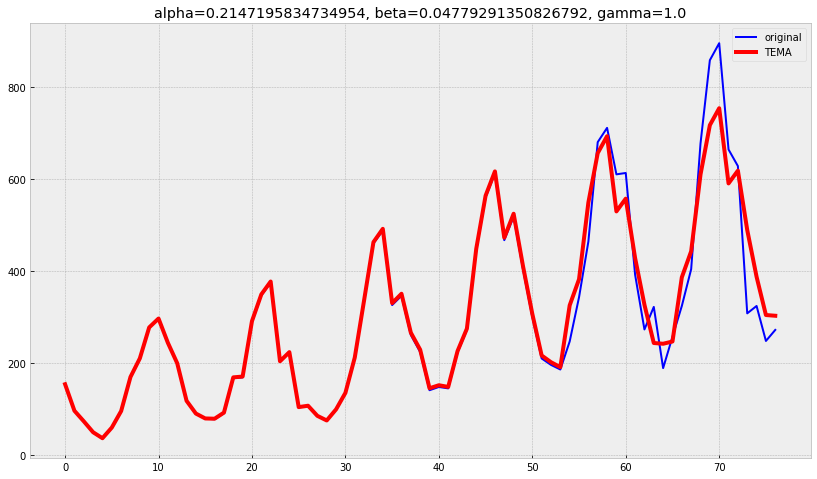

In [439]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(test))

In [440]:
# отличный результат. Ошибка всего 5863.200338538195

2.5.2. Тройное экспоненциальное сглаживание для female_births

In [441]:
series = female_births["Count"]

In [442]:
# определим границу, до которой будет трейн, после которой тест
board = round(series.shape[0] * 0.7)
board

255

In [443]:
# разбиваем на трейн и тест
train, test = series[:board], series[board:]

In [444]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [445]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 74.72417639403861
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([852.11820391,   0.        ,  65.43343147])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 0
   status: 0
  success: True
        x: array([0., 0., 0.])


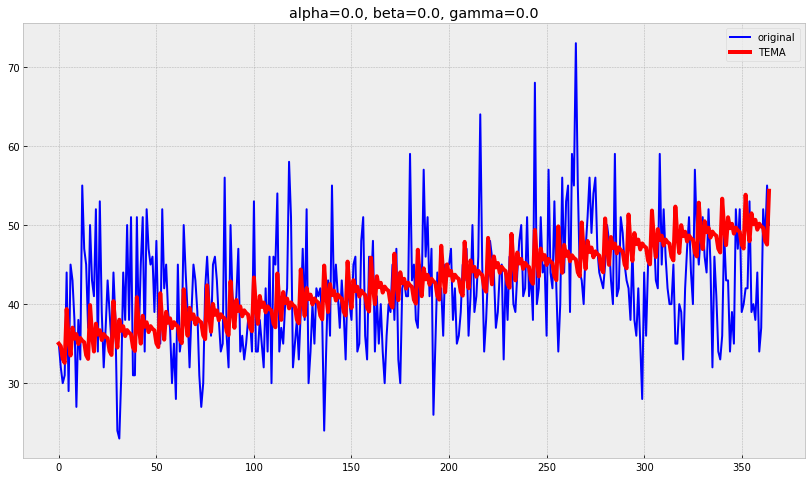

In [446]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(test))

In [447]:
# интересный результат. Значение ошибки хорошее - 74.72417639403861. Но хуже, чем у DEMA